In [1]:
import torch, random
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Audio
from matplotlib import pyplot as plt
from diffusers import DiffusionPipeline, AudioPipelineOutput
from torchaudio import transforms as AT
from torchvision import transforms as IT

/home/matteoc/miniconda3/envs/huggin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load a pre-trained audio diffusion pipeline
device = "cuda:4" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-instrumental-hiphop-256").to(device)

unet/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


100%|██████████| 1000/1000 [00:28<00:00, 35.08it/s]


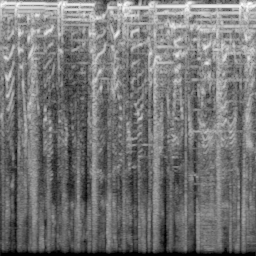

In [3]:
# Sample from the pipeline and display the outputs
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))

In [4]:
# The audio array
print(output.audios[0].shape)

# The output image (spectrogram)
print(output.images[0].size)



(1, 130560)
(256, 256)


tensor(6.1201e-15) tensor(1.5653)


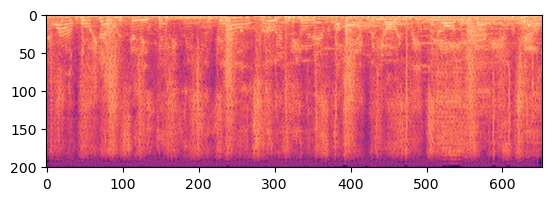

In [8]:
# Calculate and show a spectrogram for our generated audio sample using torchaudio
spec_transform = AT.Spectrogram(power=2)
spectrogram = spec_transform(torch.tensor(output.audios[0]))
print(spectrogram.min(), spectrogram.max())
log_spectrogram = spectrogram.log()
plt.imshow(log_spectrogram[0], cmap="magma")

(130560,)


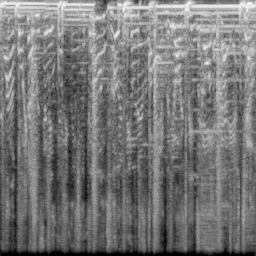

In [9]:
a = pipe.mel.image_to_audio(output.images[0])
print(a.shape)

pipe.mel.load_audio(raw_audio=a)
im = pipe.mel.audio_slice_to_image(0)
im

In [13]:
sample_rate_pipeline = pipe.mel.get_sample_rate()
print(sample_rate_pipeline)

display(Audio(output.audios[0], rate=sample_rate_pipeline*2))  # 2x speed

22050


## Fine-tuining

In [14]:
from datasets import load_dataset

dataset = load_dataset("lewtun/music_genres", split="train")
dataset

Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 19909
})

In [15]:
for g in list(set(dataset["genre"])):
    print(g, sum(x == g for x in dataset["genre"]))

International 814
Chiptune / Glitch 1181
Pop 945
Blues 58
Spoken 94
Easy Listening 13
Folk 1214
Rock 3095
Hip-Hop 1757
Punk 2582
Experimental 1800
Classical 495
Ambient Electronic 796
Soul-RnB 94
Jazz 306
Old-Time / Historic 408
Country 142
Instrumental 1044
Electronic 3071


In [19]:
audio_array = dataset[0]
print(audio_array)

{'audio': {'path': None, 'array': array([ 3.97140226e-07,  7.30310290e-07,  7.56406735e-07, ...,
       -1.19636677e-01, -1.16811886e-01, -1.12441722e-01]), 'sampling_rate': 44100}, 'song_id': 0, 'genre_id': 0, 'genre': 'Electronic'}


In [26]:
piece = 235
audio_array = dataset[piece]["audio"]["array"]
sample_rate_dataset = dataset[piece]["audio"]["sampling_rate"]
genre = dataset[piece]["genre"]
genre_id = dataset[piece]["genre_id"]
print("Audio array shape:", audio_array.shape)
print("Audio array genre:", genre)
print("Audio array genre_id:", genre_id)
print("Sample rate:", sample_rate_dataset)
display(Audio(audio_array, rate=sample_rate_dataset))

Audio array shape: (1321967,)
Audio array genre: Experimental
Audio array genre_id: 3
Sample rate: 44100


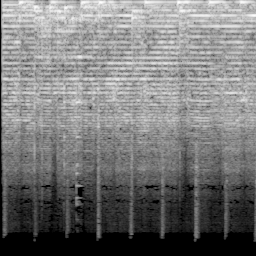

In [27]:
a = dataset[piece]["audio"]["array"]  # Get the audio array
pipe.mel.load_audio(raw_audio=a)  # Load it with pipe.mel
pipe.mel.audio_slice_to_image(0)  # View the first 'slice' as a spectrogram

In [28]:
resampler = AT.Resample(sample_rate_dataset, sample_rate_pipeline, dtype=torch.float32)
to_t = IT.ToTensor()


def to_image(audio_array):
    audio_tensor = torch.tensor(audio_array).to(torch.float32)
    audio_tensor = resampler(audio_tensor)
    pipe.mel.load_audio(raw_audio=np.array(audio_tensor))
    num_slices = pipe.mel.get_number_of_slices()
    slice_idx = random.randint(0, num_slices - 1)  # Pic a random slice each time (excluding the last short slice)
    im = pipe.mel.audio_slice_to_image(slice_idx)
    return im

In [29]:
def collate_fn(examples):
    # to image -> to tensor -> rescale to (-1, 1) -> stack into batch
    audio_ims = [to_t(to_image(x["audio"]["array"])) * 2 - 1 for x in examples]
    return torch.stack(audio_ims)


# Create a dataset with only the 'Chiptune / Glitch' genre of songs
batch_size = 4  # 4 on colab, 12 on A100
chosen_genre = "Electronic"  # <<< Try training on different genres <<<
indexes = [i for i, g in enumerate(dataset["genre"]) if g == chosen_genre]
filtered_dataset = dataset.select(indexes)
dl = torch.utils.data.DataLoader(
    filtered_dataset.shuffle(), batch_size=batch_size, collate_fn=collate_fn, shuffle=True
)
batch = next(iter(dl))
print(batch.shape)

torch.Size([4, 1, 256, 256])


In [ ]:
epochs = 3
lr = 1e-4

pipe.unet.train()
pipe.scheduler.set_timesteps(1000)
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr)

for epoch in range(epochs):
    for step, batch in tqdm(enumerate(dl), total=len(dl)):

        # Prepare the input images
        clean_images = batch.to(device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, pipe.scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        noisy_images = pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

## MusicCAPS

In [2]:
from datasets import load_dataset

ds = load_dataset('google/MusicCaps', split='train')

import subprocess
import os
from pathlib import Path

def download_clip(
    video_identifier,
    output_filename,
    start_time,
    end_time,
    tmp_dir='/tmp/musiccaps/',
    num_attempts=5,
    url_base='https://www.youtube.com/watch?v='
):
    status = False

    command = f"""
        yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_filename}" --download-sections "*{start_time}-{end_time}" {url_base}{video_identifier}
    """.strip()

    attempts = 0
    while True:
        try:
            output = subprocess.check_output(command, shell=True,
                                                stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as err:
            attempts += 1
            if attempts == num_attempts:
                return status, err.output
        else:
            break

    # Check if the video was successfully saved.
    status = os.path.exists(output_filename)
    return status, 'Downloaded'

In [3]:
from datasets import Audio as audiod

samples_to_load = 5521      # How many samples to load
cores = 4                 # How many processes to use for the loading
sampling_rate = 44100     # Sampling rate for the audio, keep in 44100
writer_batch_size = 1000  # How many examples to keep in memory per worker. Reduce if OOM.
data_dir = "/srv/nfs-data/sisko/matteoc/music/music_data_caps" # Where to save the data

# Just select some samples 
ds = ds.select(range(samples_to_load))

# Create directory where data will be saved
data_dir = Path(data_dir)
data_dir.mkdir(exist_ok=True, parents=True)

def process(example):
    outfile_path = str(data_dir / f"{example['ytid']}.wav")
    status = True
    if not os.path.exists(outfile_path):
        status = False
        status, log = download_clip(
            example['ytid'],
            outfile_path,
            example['start_s'],
            example['end_s'],
        )

    example['audio'] = outfile_path
    example['download_status'] = status
    return example

In [4]:
ds = ds.map(
        process,
        num_proc=cores,
        writer_batch_size=writer_batch_size,
        keep_in_memory=False
    ).cast_column('audio', audiod(sampling_rate=sampling_rate))

In [5]:
song_idx = 3799
audio_array = ds[song_idx]["audio"]["array"]
audio_caption = ds[song_idx]["caption"]
sample_rate_dataset = ds[song_idx]["audio"]["sampling_rate"]
print("Audio array shape:", audio_array.shape)
print("Audio caption:", audio_caption)
print("Sample rate:", sample_rate_dataset)
display(Audio(audio_array, rate=sample_rate_dataset))

Audio array shape: (880832,)
Audio caption: The low quality recording features a classical song that consists of a brass solo melody played over sustained brass melody and short flute lick. It sounds emotional, joyful and the recording is noisy.
Sample rate: 44100


## FT using HF tutorial

In [54]:
from diffusers import MusicLDMPipeline
device = "cuda:3" if torch.cuda.is_available() else "cpu"

repo_id = "ucsd-reach/musicldm"
pipe = MusicLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float32)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


In [8]:
resampler = AT.Resample(sample_rate_dataset, pipe.feature_extractor.sampling_rate, dtype=torch.double)
to_t = IT.ToTensor()


In [9]:
input_ids = pipe.tokenizer([audio_caption], padding=True, return_tensors="pt")
with torch.no_grad():
    # text_embeddings_last = pipe.text_encoder.text_model(**input_ids.to(device))["last_hidden_state"]
    text_embeddings_last = pipe.text_encoder.text_model(**input_ids.to(device))["last_hidden_state"]
print("Text embeddings shape:", text_embeddings_last.shape)

text_embeddings = pipe._encode_prompt(audio_caption, device, 1, False, "")
print("Text embeddings feature:", text_embeddings.shape)

Text embeddings shape: torch.Size([1, 39, 768])
Text embeddings feature: torch.Size([1, 512])


In [32]:
audio_array = torch.tensor(audio_array).double()
audio_feat_pre = pipe.feature_extractor(resampler(audio_array), sampling_rate=pipe.feature_extractor.sampling_rate)
audio_feat = torch.tensor(audio_feat_pre['input_features'][0]).unsqueeze(0)
print("Input audio shape:", audio_feat.shape)

pipe.vae.float()
encoded = pipe.vae.encode(audio_feat.to(device))
latents_real = 0.18215 * encoded.latent_dist.mean
print("Encoded latents shape:", latents_real.shape)
decoded_audio = pipe.vae.decode(latents_real / 0.18215).sample
print("Decoded audio shape:", decoded_audio.shape)

/tmp/ipykernel_1412261/2326041860.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio_array = torch.tensor(audio_array).double()


Input audio shape: torch.Size([1, 1, 1001, 64])
Encoded latents shape: torch.Size([1, 8, 250, 16])
Decoded audio shape: torch.Size([1, 1, 1000, 64])


In [43]:
print(pipe.unet.config)



FrozenDict([('sample_size', 256), ('in_channels', 8), ('out_channels', 8), ('center_input_sample', False), ('flip_sin_to_cos', True), ('freq_shift', 0), ('down_block_types', ['DownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D', 'CrossAttnDownBlock2D']), ('mid_block_type', 'UNetMidBlock2DCrossAttn'), ('up_block_types', ['CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'CrossAttnUpBlock2D', 'UpBlock2D']), ('only_cross_attention', False), ('block_out_channels', [128, 256, 384, 640]), ('layers_per_block', 2), ('downsample_padding', 1), ('mid_block_scale_factor', 1), ('dropout', 0.0), ('act_fn', 'silu'), ('norm_num_groups', 32), ('norm_eps', 1e-05), ('cross_attention_dim', [128, 256, 384, 640]), ('transformer_layers_per_block', 1), ('reverse_transformer_layers_per_block', None), ('encoder_hid_dim', None), ('encoder_hid_dim_type', None), ('attention_head_dim', 8), ('num_attention_heads', None), ('dual_cross_attention', False), ('use_linear_projection', False), ('class_embed_type', 'simp

In [ ]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 8, 250, 16).to(device)
text_embeddings = torch.randn(1, 8, 640).to(device)
class_labels = torch.randn(1, 512).to(device).to(torch.float32)

# Model prediction
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, encoder_hidden_states=text_embeddings, class_labels=class_labels).sample

print("UNet output shape:", unet_output.shape)  

## FT using HG MusicLDMPipeline git

In [55]:
from diffusers import MusicLDMPipeline

repo_id = "ucsd-reach/musicldm"
pipe = MusicLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float32)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s]


In [12]:
from transformers import AutoFeatureExtractor, ClapModel, ClapProcessor

clap_model_id = "laion/larger_clap_music_and_speech"
clap_model = ClapModel.from_pretrained(clap_model_id).to(device)
processor = ClapProcessor.from_pretrained(clap_model_id)

In [14]:
audio_array = torch.tensor(audio_array).double()
resampler = AT.Resample(sample_rate_dataset, pipe.feature_extractor.sampling_rate, dtype=torch.double)

with torch.no_grad():
    audio_array_0 = resampler(audio_array)
    inputs_0 = processor(text=audio_caption, audios=audio_array_0.squeeze(), return_tensors="pt", sampling_rate=48_000)
    audio_outputs = clap_model(**inputs_0.to("cuda:4"))

with torch.no_grad():
    audio_array = resampler(audio_array)
    inputs = processor(audios=audio_array.squeeze(), return_tensors="pt", sampling_rate=48_000)
    audio_features = clap_model.get_audio_features(inputs.input_features.to("cuda:4"))

/tmp/ipykernel_1369716/4087187231.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio_array = torch.tensor(audio_array).double()


In [15]:
audio_outputs.audio_embeds.shape, audio_features.shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [56]:
prompt_embeds = pipe._encode_prompt(
            audio_caption,
            device,
            num_waveforms_per_prompt=1,
            do_classifier_free_guidance=False,
            negative_prompt='',
            prompt_embeds=None,
            negative_prompt_embeds=None,
        )

# input_ids = pipe.tokenizer([audio_caption], padding=True, return_tensors="pt")
# with torch.no_grad():
#     # text_embeddings_last = pipe.text_encoder.text_model(**input_ids.to(device))["last_hidden_state"]
#     text_embeddings_last = pipe.text_encoder.text_model(**input_ids.to(device))["last_hidden_state"]
# print("Text embeddings shape:", text_embeddings_last.shape)

In [57]:
prompt_embeds.shape

torch.Size([1, 512])

In [58]:
pipe.scheduler.set_timesteps(num_inference_steps=50, device=device)
timesteps = pipe.scheduler.timesteps
print(timesteps)
        

tensor([981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721,
        701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441,
        421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161,
        141, 121, 101,  81,  61,  41,  21,   1], device='cuda:3')


In [59]:
pipe.unet.config.in_channels

8

In [60]:
np.prod(pipe.vocoder.config.upsample_rates) / pipe.vocoder.config.sampling_rate

0.01

In [61]:
# 5. Prepare latent variables
gpu_id = 3
num_channels_latents = pipe.unet.config.in_channels
latents = pipe.prepare_latents(
    1,  # 1 = batch_size  --> da moltiplicare se num_waveforms_per_prompt > 1
    num_channels_latents,
    1000,  # height
    torch.float32,
    torch.device(f"cuda:{gpu_id}"),
    generator=torch.Generator(device=f"cuda:{gpu_id}").manual_seed(song_idx),
    latents=None,
)


In [62]:
latents.shape

torch.Size([1, 8, 250, 16])

In [63]:
num_inference_steps = 50
do_classifier_free_guidance = False
cross_attention_kwargs = None
guidance_scale = 2.0
callback = None
callback_steps = 1
extra_step_kwargs= {}
extra_step_kwargs["eta"] = 0.0
extra_step_kwargs["generator"] = torch.Generator(device=f"cuda:{gpu_id}").manual_seed(song_idx)

In [64]:
num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
with pipe.progress_bar(total=num_inference_steps) as progress_bar:
    for i, t in enumerate(timesteps):
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(
            latent_model_input,
            t,
            encoder_hidden_states=None,
            # class_labels=audio_outputs.audio_embeds,
            class_labels=prompt_embeds,
            cross_attention_kwargs=cross_attention_kwargs,
            return_dict=False,
        )[0]

        # with torch.no_grad():
        #     noise_pred = pipe.unet(
        #         latent_model_input,
        #         t,
        #         encoder_hidden_states=text_embeddings_last,
        #         class_labels=None,
        #         cross_attention_kwargs=cross_attention_kwargs,
        #         return_dict=False,
        #     )[0]

        # perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

        # call the callback, if provided
        if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
            progress_bar.update()
            if callback is not None and i % callback_steps == 0:
                step_idx = i // getattr(pipe.scheduler, "order", 1)
                callback(step_idx, t, latents)

100%|██████████| 50/50 [00:04<00:00, 11.71it/s]


In [65]:
latents.shape

torch.Size([1, 8, 250, 16])

In [66]:
output_type = "np"
if not output_type == "latent":
    latents = 1 / pipe.vae.config.scaling_factor * latents
    mel_spectrogram = pipe.vae.decode(latents).sample

In [ ]:
pipe = pipe.to(device)
audio_length_in_s = 10.0
original_waveform_length = int(audio_length_in_s * pipe.vocoder.config.sampling_rate)
audio = pipe.mel_spectrogram_to_waveform(mel_spectrogram.to(device=device))
audio = audio[:, :original_waveform_length]

In [68]:
pipe.vocoder.config.sampling_rate, original_waveform_length

(16000, 160000)

In [69]:
if output_type == "np":
    audio = audio.detach().numpy()

In [70]:
audio_pipe = AudioPipelineOutput(audios=audio)

In [71]:
audio_pipe

AudioPipelineOutput(audios=array([[-0.00919026, -0.00409667,  0.00599698, ..., -0.00107131,
         0.00343562,  0.0072836 ]], dtype=float32))

In [72]:
from IPython.display import Audio

Audio(audio_pipe[0], rate=16000)

## StableAudioPipeline

In [10]:
import torch
import soundfile as sf
from diffusers import StableAudioPipeline

pipe = StableAudioPipeline.from_pretrained("stabilityai/stable-audio-open-1.0", torch_dtype=torch.float16)
device = 'cuda:1'
pipe = pipe.to(device)

Loading pipeline components...:  17%|█▋        | 1/6 [00:05<00:26,  5.24s/it]/home/matteoc/miniconda3/envs/huggin/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Loading pipeline components...: 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


In [11]:
prompt = "The sound of a hammer hitting a wooden surface."
negative_prompt = "Low quality."

generator = torch.Generator("cuda").manual_seed(0)

In [14]:
pipe

StableAudioPipeline {
  "_class_name": "StableAudioPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stabilityai/stable-audio-open-1.0",
  "projection_model": [
    "stable_audio",
    "StableAudioProjectionModel"
  ],
  "scheduler": [
    "diffusers",
    "CosineDPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "StableAudioDiTModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderOobleck"
  ]
}

In [12]:
prompt_embeds = pipe.encode_prompt(
            prompt,
            device=device,
            do_classifier_free_guidance=7.0,
            negative_prompt=negative_prompt,
            prompt_embeds=None,
            negative_prompt_embeds=None,
            attention_mask=None,
            negative_attention_mask=None,
        )

In [13]:
prompt_embeds.shape

torch.Size([2, 128, 768])